In [14]:
import torch
import normflows as nf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader as dl
from torch.utils.data import TensorDataset as ds

In [15]:
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
device

device(type='cuda')

In [16]:
target = nf.distributions.TwoMoons()
base = nf.distributions.DiagGaussian(2)

In [17]:
def data_loader_generator(number_of_samples,batchsize):
    data_points = target.sample(number_of_samples)
    target_data_set = ds(data_points)
    target_data_loader = dl(target_data_set,batch_size=batchsize,shuffle=True)
    return target_data_loader


In [18]:
def flow_init():
    K = 7

    latent_size = 2
    hidden_units = 270
    hidden_layers = 2

    flows = []
    for i in range(K):
        flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
        flows += [nf.flows.LULinearPermute(latent_size)]

    # Set base distribution
    q0 = base
        
    # Construct flow model
    model = nf.NormalizingFlow(q0, flows)

    return(model)


In [19]:
def train_model(model, target_data_loader, number_epochs):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    tolerance = 0.0001
    previous_loss = float('inf')  # Initialize with a large value
    early_stop = False
    losses = []
    for epoch in range(number_epochs):
        if not early_stop:
            model.train()
            for data in target_data_loader:
                optimizer.zero_grad()
                
                data = data[0].to(device) 
                loss = model.forward_kld(data)
                
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                
                current_loss = loss.item()
                losses.append(loss.item())
                if epoch > 0:
                    loss_diff = abs(current_loss - previous_loss)
                    if loss_diff < tolerance:
                        early_stop = True
                        print(f"Early stopping at epoch {epoch+1} with loss difference {loss_diff:.6f}")
                        break
                
                previous_loss = current_loss
    plt.figure()
    plt.plot(losses)
    plt.show()
    return model

  0%|          | 0/4 [00:00<?, ?it/s]

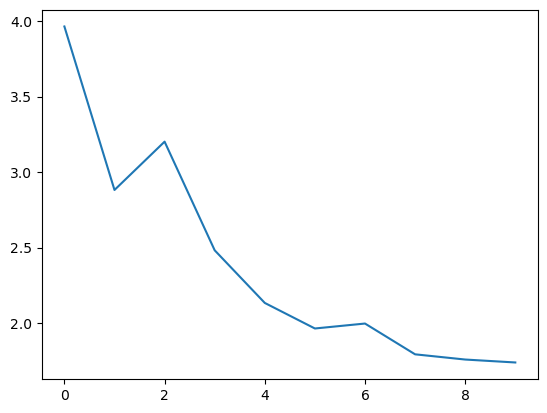

 25%|██▌       | 1/4 [00:03<00:09,  3.07s/it]

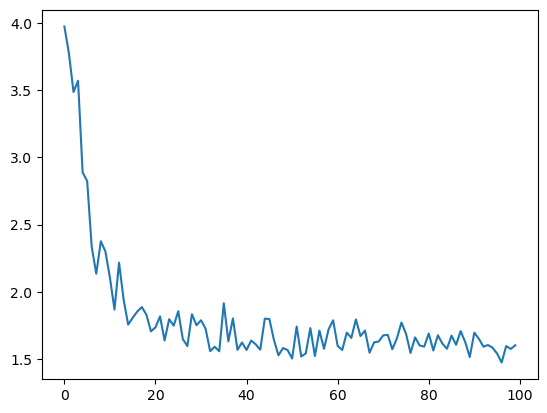

 50%|█████     | 2/4 [00:32<00:37, 18.66s/it]

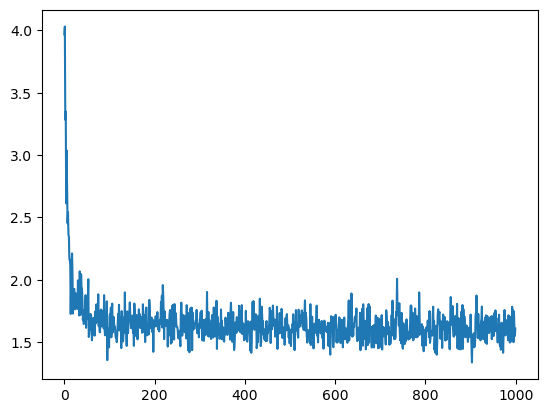

 75%|███████▌  | 3/4 [05:21<02:21, 142.00s/it]

Early stopping at epoch 3 with loss difference 0.000035


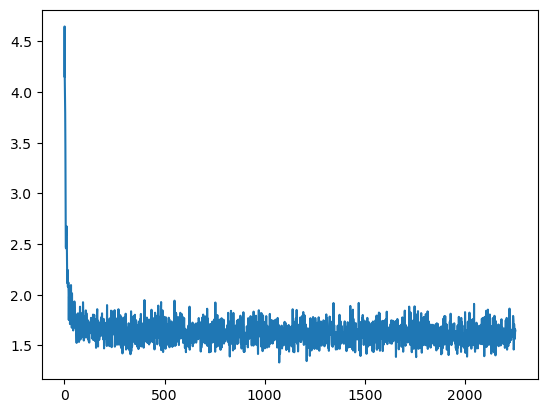

100%|██████████| 4/4 [13:35<00:00, 203.92s/it]


In [20]:
Models = []
sample_numbers = []

for numb in tqdm(range(2,6)):
    simple_models = flow_init().to(device=device)
    number_of_samples = 10**numb
    batch_size = 100
    Models.append(train_model(model=simple_models,target_data_loader=data_loader_generator(number_of_samples=number_of_samples,batchsize=batch_size),number_epochs=10))
    sample_numbers.append(number_of_samples)

This favoured a higher learning rate of 0.01

In [21]:
len(sample_numbers)

4

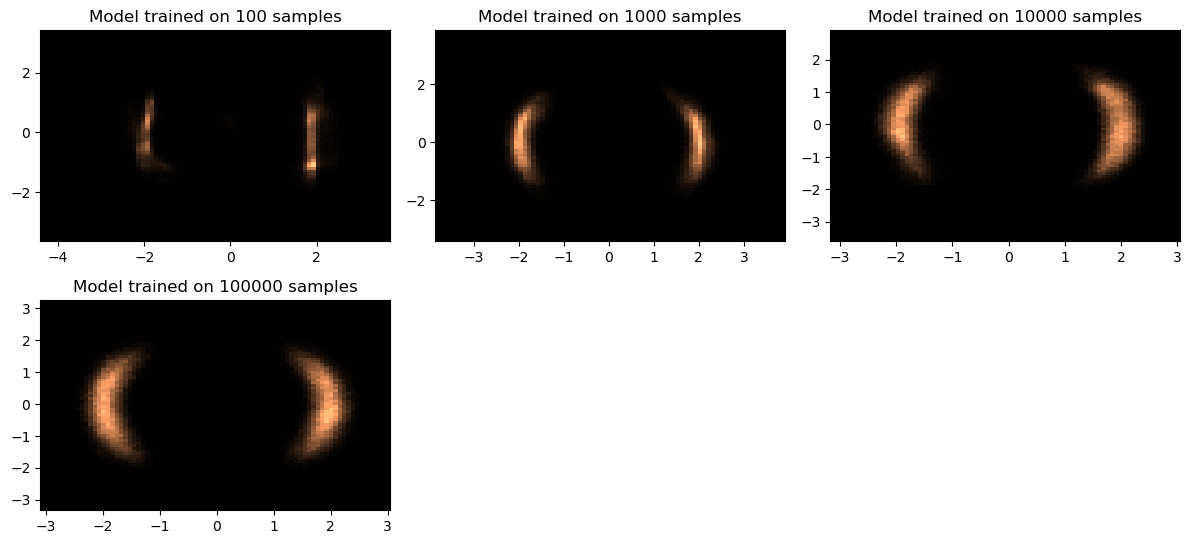

In [22]:
#checking if the models are different
plt.figure(figsize=(12,8))
with torch.no_grad():
        for i in range(len(Models)):
                k=i+1
                validation_samples = base.sample(100000).to(device)
                guesses = torch.Tensor.cpu(Models[i](validation_samples))
                plt.subplot(3,3,k)
                plt.hist2d(guesses[:,0],guesses[:,1],bins=80,cmap="copper")
                plt.title(f'Model trained on {sample_numbers[i]} samples')
                
plt.tight_layout()
plt.show()


In [23]:
KL_for_different_models=[]

x = target.sample(1000).detach().to(device)        
log_prob_target = target.log_prob(x)

with torch.no_grad():
        for i in tqdm(range(len(Models))):
                        KL_for_current_sample_size = []
                        log_prob_model = Models[i].log_prob(x)
                        KL_target_model = (log_prob_target - log_prob_model).mean()

                        KL_for_different_models.append(KL_target_model.item())

100%|██████████| 4/4 [00:00<00:00,  8.83it/s]


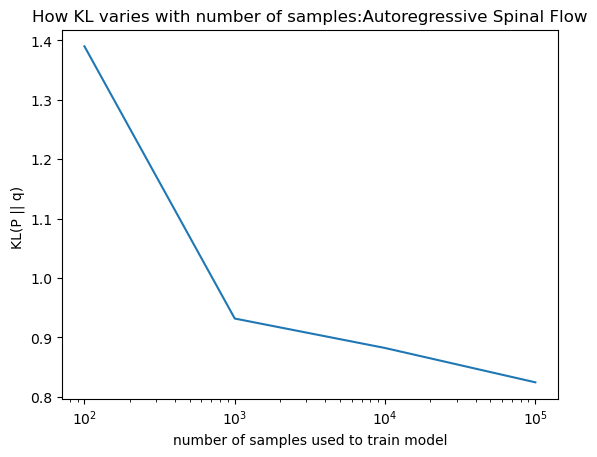

In [24]:
#plotting to see how KL Divergence values differes with number of samples
plt.plot(sample_numbers,KL_for_different_models)
plt.xlabel('number of samples used to train model')
plt.ylabel('KL(P || q) ')
plt.xscale('log')
plt.title('How KL varies with number of samples:Autoregressive Spinal Flow')
plt.show()

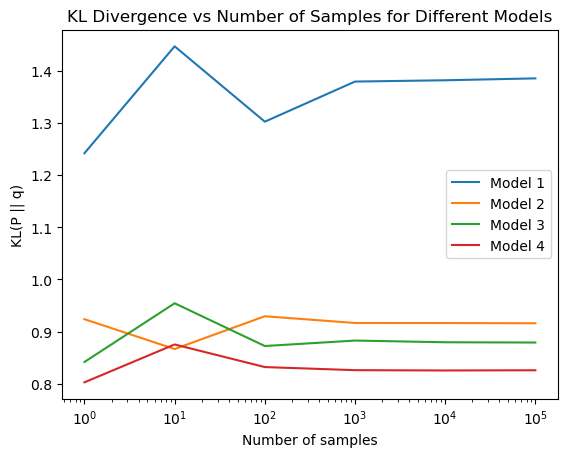

In [25]:
plt.figure()

for model_idx, model in enumerate(Models):
    KL = []
    sample_number = []

    for numb in range(6):
        number_of_samples = 10**numb
        sample_number.append(number_of_samples)
        
        KL_for_current_sample_size = []

        for _ in range(10): 
            x = target.sample(number_of_samples).detach().to(device)

            log_prob_target = target.log_prob(x)
            log_prob_model = model.log_prob(x)

            KL_target_model = (log_prob_target - log_prob_model).mean()

            KL_for_current_sample_size.append(KL_target_model.item())

        KL.append(np.mean(KL_for_current_sample_size))

    plt.plot(sample_number, KL, label=f"Model {model_idx + 1}")

plt.xlabel('Number of samples')
plt.ylabel('KL(P || q)')
plt.xscale('log')
plt.title('KL Divergence vs Number of Samples for Different Models')
plt.legend()
plt.show()


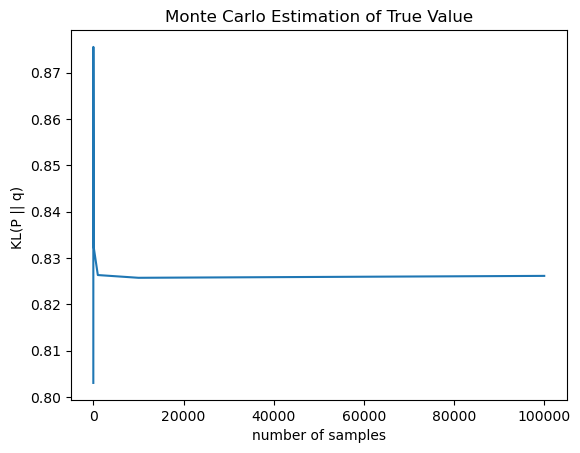

In [26]:
plt.plot(sample_number,KL)
plt.xlabel('number of samples')
plt.ylabel('KL(P || q) ')
plt.title('Monte Carlo Estimation of True Value')
plt.show()